In [41]:
# Import libraries
import math
import pandas_datareader as web
import  numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('fivethirtyeight')
import numpy as np
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [42]:
# Description: This program predicts the price of Bitcoin for the next 30 days


In [43]:

import pandas_datareader.data as web
import datetime    
start = datetime.datetime(2012, 1, 3)
end = datetime.datetime(2021, 4, 15)
df = web.DataReader("ETH-USD", 'yahoo', start, end)

dates =[]
for x in range(len(df)):
    newdate = str(df.index[x])
    newdate = newdate[0:10]
    dates.append(newdate)

df['date'] = dates


In [44]:
df.reset_index(inplace=True,drop=False)

In [45]:
df['Date']

0      2015-08-06
1      2015-08-07
2      2015-08-08
3      2015-08-09
4      2015-08-10
          ...    
2071   2021-04-11
2072   2021-04-12
2073   2021-04-13
2074   2021-04-14
2075   2021-04-15
Name: Date, Length: 2076, dtype: datetime64[ns]

In [51]:
df



,Date,High,Low,Open,Close,Volume,Adj Close,date
0,2015-08-06,3.536610,2.521120,2.831620,2.772120,1.643290e+05,2.772120,2015-08-06
1,2015-08-07,2.798810,0.714725,2.793760,0.753325,6.741880e+05,0.753325,2015-08-07
2,2015-08-08,0.879810,0.629191,0.706136,0.701897,5.321700e+05,0.701897,2015-08-08
3,2015-08-09,0.729854,0.636546,0.713989,0.708448,4.052830e+05,0.708448,2015-08-09
4,2015-08-10,1.131410,0.663235,0.708087,1.067860,1.463100e+06,1.067860,2015-08-10
...,...,...,...,...,...,...,...,...
2071,2021-04-11,2199.718750,2110.368896,2157.361816,2139.353271,2.172794e+10,2139.353271,2021-04-11
2072,2021-04-12,2318.423340,2138.559570,2139.364258,2299.187744,2.945664e+10,2299.187744,2021-04-12
2073,2021-04-13,2449.687500,2284.563721,2299.347900,2435.104980,3.559282e+10,2435.104980,2021-04-13
2074,2021-04-14,2544.267334,2409.924072,2436.034668,2519.116211,3.232561e+10,2519.116211,2021-04-14


In [52]:
df.head(7)



,Date,High,Low,Open,Close,Volume,Adj Close,date
0,2015-08-06,3.536610,2.521120,2.831620,2.772120,164329.0,2.772120,2015-08-06
1,2015-08-07,2.798810,0.714725,2.793760,0.753325,674188.0,0.753325,2015-08-07
2,2015-08-08,0.879810,0.629191,0.706136,0.701897,532170.0,0.701897,2015-08-08
3,2015-08-09,0.729854,0.636546,0.713989,0.708448,405283.0,0.708448,2015-08-09
4,2015-08-10,1.131410,0.663235,0.708087,1.067860,1463100.0,1.067860,2015-08-10
5,2015-08-11,1.289940,0.883608,1.058750,1.217440,2150620.0,1.217440,2015-08-11
6,2015-08-12,1.965070,1.171990,1.222240,1.827670,4068680.0,1.827670,2015-08-12


In [53]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])




In [54]:
#Variables for training
# cols = list(df)[0:1]


In [55]:
#Variables for training
cols = list(df)[1:6]

In [56]:
cols

['High', 'Low', 'Open', 'Close', 'Volume']

In [57]:
df_for_training = df[cols].astype(float)

<AxesSubplot:>

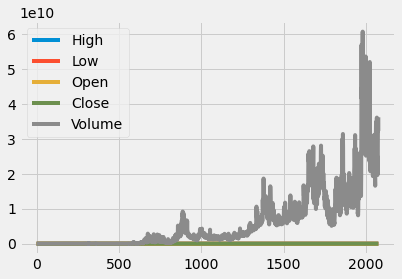

In [58]:
df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

In [59]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)

df_for_training_scaled = scaler.transform(df_for_training)



In [60]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

trainX = []
trainY = []

In [61]:
n_future = 1 # Number of days we want to predict into the future
n_past = 150 # Number of past days we want to use to predict the future


for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (1926, 150, 5).
trainY shape == (1926, 1).


In [62]:
# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150, 64)           17920     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [63]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)



Epoch 1/10
109/109 [==============================] - 15s 106ms/step - loss: 0.1272 - val_loss: 1.2533
Epoch 2/10
109/109 [==============================] - 11s 102ms/step - loss: 0.0280 - val_loss: 0.2829
Epoch 3/10
109/109 [==============================] - 11s 102ms/step - loss: 0.0245 - val_loss: 0.2438
Epoch 4/10
109/109 [==============================] - 11s 103ms/step - loss: 0.0209 - val_loss: 0.2571
Epoch 5/10
109/109 [==============================] - 11s 102ms/step - loss: 0.0154 - val_loss: 0.1571
Epoch 6/10
109/109 [==============================] - 11s 102ms/step - loss: 0.0155 - val_loss: 0.0826
Epoch 7/10
109/109 [==============================] - 11s 103ms/step - loss: 0.0153 - val_loss: 0.1435
Epoch 8/10
109/109 [==============================] - 11s 104ms/step - loss: 0.0178 - val_loss: 0.1001
Epoch 9/10
109/109 [==============================] - 11s 104ms/step - loss: 0.0132 - val_loss: 0.1195
Epoch 10/10
109/109 [==============================] - 11s 104ms/step - l

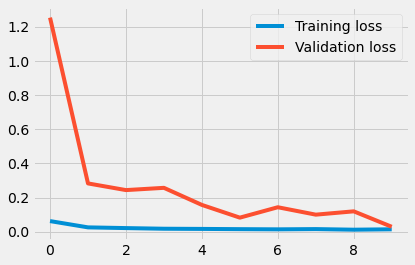

In [64]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [65]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future= 150 #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

In [66]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


In [67]:
# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Close':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


<ipython-input-68-36b5c3f76479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
/home/thembajsph/Downloads/anaconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/thembajsph/Downloads/anaconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit ke

<AxesSubplot:xlabel='Date', ylabel='Close'>

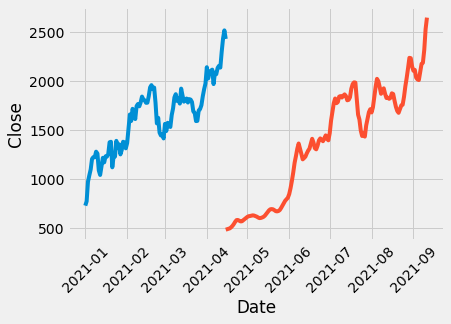

In [68]:
original = df[['Date', 'Close']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-1-1']
plt.xticks(rotation=45)

sns.lineplot(original['Date'], original['Close'])
sns.lineplot(df_forecast['Date'], df_forecast['Close'])

In [83]:
df_forecast.head(81)


,Date,Close
0,2021-04-15,484.882996
1,2021-04-16,489.322205
2,2021-04-17,492.854919
3,2021-04-18,498.520660
4,2021-04-19,509.697296
...,...,...
76,2021-06-30,1397.265625
77,2021-07-01,1470.403687
78,2021-07-02,1599.434692
79,2021-07-03,1688.540894


In [70]:
#Description: This program uses the Moving Average Convergence/Divergence (MACD) crossover
#             to determine when to buy and sell stock.


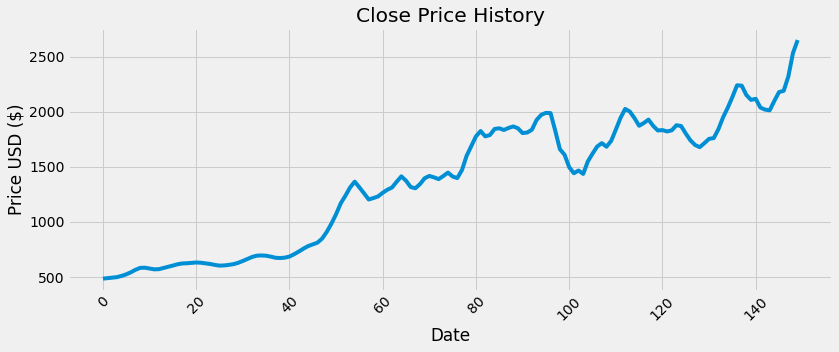

In [71]:
#Visually show the stock price 
plt.figure(figsize=(12.2, 4.5))
plt.plot(df_forecast['Close'], label='Close')
plt.xticks(rotation=45)
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.show()

In [72]:
#Prepare the data to calculate the RSI

#First get the difference in price from the previous day
delta = df_forecast['Close'].diff(1)

delta

0             NaN
1        4.439209
2        3.532715
3        5.665741
4       11.176636
          ...    
145     79.730225
146     11.742676
147    130.588623
148    213.090820
149    116.682861
Name: Close, Length: 150, dtype: float32

In [73]:
#Get rii NaN
delta = delta.dropna()
delta

1        4.439209
2        3.532715
3        5.665741
4       11.176636
5       14.318451
          ...    
145     79.730225
146     11.742676
147    130.588623
148    213.090820
149    116.682861
Name: Close, Length: 149, dtype: float32

In [74]:
#Get the positive gains(up) and the negative gains (down)
up = delta.copy()
down = delta.copy()

up[up <0 ]= 0
down[down > 0] = 0

In [75]:
#Get the time period
period = 14
#Calculate the avarage gain and the average loss
AVG_Gain = up.rolling(window=period).mean()
AVG_Loss = abs(down.rolling(window=period).mean())



In [76]:
#Calculate the RSI

#Calculate the Relative Strength (RS)
RS = AVG_Gain / AVG_Loss

#Calculate the Relative Strength Index (RSI)
RSI = 100.0 - (100.0 / (1.0 + RS))

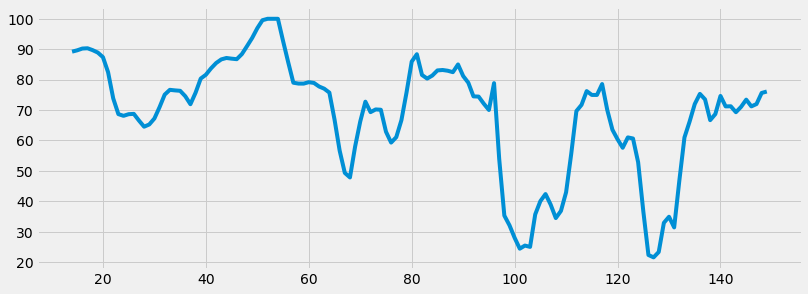

In [77]:
#Show the RSI Visually
plt.figure(figsize=(12.2, 4.5))
RSI.plot()
plt.show()

In [78]:
#Put it all together

#Create a new data frame
new_df = pd.DataFrame()
new_df['Close'] = df_forecast['Close']
new_df['RSI'] = RSI
new_df.head(41)

,Close,RSI
0,484.882996,NaN
1,489.322205,NaN
2,492.854919,NaN
3,498.520660,NaN
4,509.697296,NaN
5,524.015747,NaN
6,542.917236,NaN
7,565.804871,NaN
8,582.729980,NaN
9,584.161011,NaN


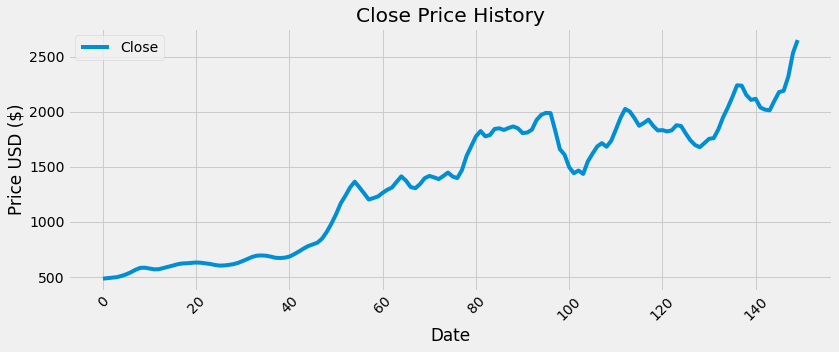

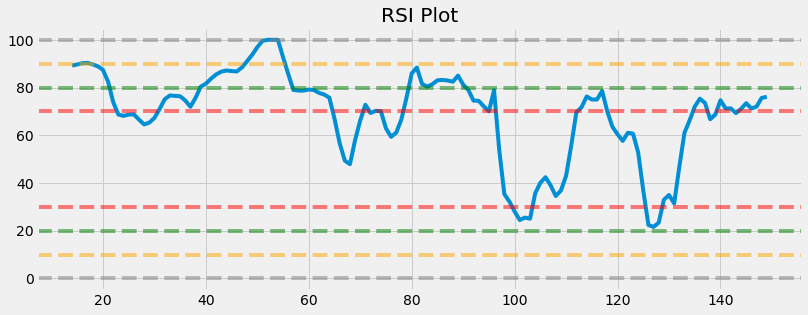

In [79]:
#Visually show the adj Close Price and RSI

#Plot the adjusted close price
plt.figure(figsize=(12.2, 4.5))
plt.plot(new_df.index, new_df['Close'], label='Close')
plt.xticks(rotation=45)
plt.title('Close Price History')
plt.legend(new_df.columns.values, loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Price USD ($)')
plt.show()
#Plot the corrresponding RSI values and significant levels
plt.figure(figsize=(12.2, 4.5))
plt.title('RSI Plot')
plt.plot(new_df.index, new_df['RSI'])
plt.axhline(0, linestyle= '--', alpha = 0.5, color= 'gray')
plt.axhline(10, linestyle= '--', alpha = 0.5, color= 'orange')
plt.axhline(20, linestyle= '--', alpha = 0.5, color= 'green')
plt.axhline(30, linestyle= '--', alpha = 0.5, color= 'red')
plt.axhline(70, linestyle= '--', alpha = 0.5, color= 'red')
plt.axhline(80, linestyle= '--', alpha = 0.5, color= 'green')
plt.axhline(90, linestyle= '--', alpha = 0.5, color= 'orange')
plt.axhline(100, linestyle= '--', alpha = 0.5, color= 'gray')
plt.show()